## Segundo prompt de fotografías

Este segundo prompt, generado por la siguiente instrucción a ChatGPT:
I want you to write a python code using the skit-learn api dictionary learning doing the following: 
1) import a dataset of images: suggest me a dataset easily available (NOT Olivetti) and containing about hundreds of images of about 256x256 pixels aprox. (might be other size but not small). Do not do any resize, but you can create patches of for example 16x16 to simplify 
2) learn a sparse dictionary and a sparse representation with the mentioned api 
3) comment what you are doing. Choose the correct decisions such that it is computationally feasible (not much waiting time)
In dict_learn, use max_iter instead of n_iter (the second one is outdated)

Dataset shape: (3023, 62, 47)
Total patches: (4000, 12, 12)
Dictionary shape: (50, 144)
Sparse codes shape: (4000, 50)


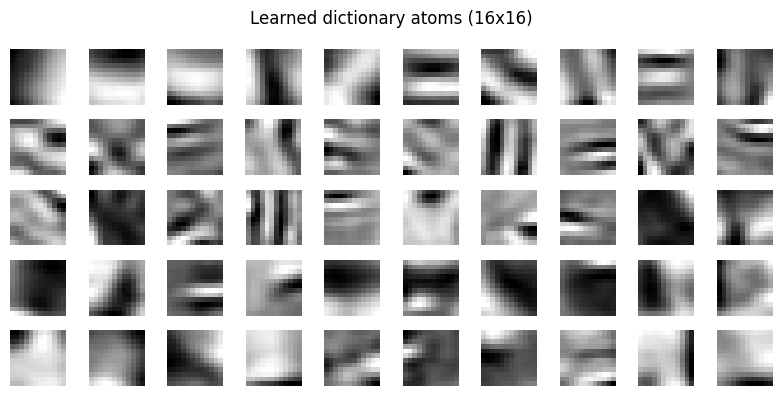

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import MiniBatchDictionaryLearning

# ----------------------------------------------------
# 1) LOAD IMAGE DATASET (LFW FACES)
# ----------------------------------------------------

# Fetch dataset (already grayscale, ~250x250 pixels)
lfw = fetch_lfw_people(min_faces_per_person=20)

images = lfw.images   # shape: (n_images, height, width)

print("Dataset shape:", images.shape)

# ----------------------------------------------------
# 2) EXTRACT SMALL PATCHES (TO MAKE LEARNING FEASIBLE)
# ----------------------------------------------------

patch_size = (12, 12)
n_patches = 4000   # limit number so computation is fast

patches = []


for img in images:
    # extract random patches from each image
    p = extract_patches_2d(img, patch_size, max_patches=20, random_state=0)
    patches.append(p)

patches = np.concatenate(patches)

# randomly keep only n_patches (for speed)
patches = patches[:n_patches]

print("Total patches:", patches.shape)

# ----------------------------------------------------
# 3) PREPROCESS PATCHES
# ----------------------------------------------------

# Flatten each patch into a vector
patches = patches.reshape(patches.shape[0], -1)

# Remove mean (important for dictionary learning)
patches -= np.mean(patches, axis=1, keepdims=True)

# Normalize variance
patches /= np.std(patches, axis=1, keepdims=True) + 1e-8

# ----------------------------------------------------
# 4) LEARN SPARSE DICTIONARY
# ----------------------------------------------------

n_components = 50   # number of dictionary atoms (reasonable size)

dict_learner = MiniBatchDictionaryLearning(
    n_components=n_components,
    batch_size=256,
    alpha=1,               # sparsity strength
    max_iter=500,
    random_state=0
)

# Learn dictionary and sparse codes
dictionary = dict_learner.fit(patches).components_

print("Dictionary shape:", dictionary.shape)

# ----------------------------------------------------
# 5) COMPUTE SPARSE REPRESENTATION OF PATCHES
# ----------------------------------------------------

sparse_codes = dict_learner.transform(patches)

print("Sparse codes shape:", sparse_codes.shape)

# ----------------------------------------------------
# 6) VISUALIZE LEARNED ATOMS
# ----------------------------------------------------

fig, axes = plt.subplots(5, 10, figsize=(8, 4))

for i, ax in enumerate(axes.flat):
    atom = dictionary[i].reshape(patch_size)
    ax.imshow(atom, cmap="gray")
    ax.axis("off")

plt.suptitle("Learned dictionary atoms (16x16)")
plt.tight_layout()
plt.show()
